# This paper shows a way to regress pose.

[Deep-6DPose: Recovering 6D Object Pose from a Single RGB Image](https://arxiv.org/abs/1802.10367v1)

### 1. Translation
> In stead of predicting full translation vector, our network is trained to regress the Z component only. Of course, It works.
>
> As we can see in below picture, if we get Zc, then we can convert pixel-coordinates (u, v) to world-coordinates (Xw, Yw, Zw).

![1](http://www.pianshen.com/images/654/e166052ae19a43a7a3e628f1722373d6.png)

### 2. Rotation
- Representing the rotation part of the pose is more complicated than the translation part, there are some ways.
 * 1 - the Euler angles wrap around at 2π radians, i.e., having multiple values representing the same angle. This causes difficulty in learning a uni-modal scalar regression task.
 * 2 - the use of 3×3 orthonormal matrix is over-parametrised, and creates the problem of enforcing the orthogonality constraint when training the network through back-propagation.
 * 3 - A final common representation is the unit length 4-dimensional quaternion. One of the downsides of quaternion representation is its norm should be unit. This constraint may harm the optimization.
 * **4 - In this work, we use the Lie algebra so(3) associated with the Lie group SO(3) (which is space of 3D rotation matrices) as our rotation representation.We choose the Lie algebra so(3) to represent the rotation because an arbitrary element of so(3) admits a skew-symmetric matrix representation parameterized by a vector in R 3 which is continuous and smooth. This means that the network needs to regress only three scalar numbers for a rotation, without any constraints.**

![1](https://img-blog.csdnimg.cn/2019041922363717.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzQwNDc1NTI5,size_16,color_FFFFFF,t_70)

### 'In summary, the pose branch is trained to regress a 4-dimensional vector, in which the first three elements represent rotation part and the last element represents the z component of the translation part of the pose.'


# Theory may seems complicated, I'll show you codes.

In [ ]:
import numpy as np
from math import sin, cos, atan2, sqrt
from cv2 import Rodrigues

In [ ]:
# Euler Angles -> Rotation Matrix -> Rotation Vector
def a2v(yaw, pitch, roll):
    # Euler Angle -> Rotation Matrix
    # I think the pitch and yaw should be exchanged
    yaw, pitch = pitch, yaw
    Y = np.array([[cos(yaw), -sin(yaw), 0],
                  [sin(yaw), cos(yaw), 0],
                  [0, 0, 1]])
    P = np.array([[cos(pitch), 0, sin(pitch)],
                  [0, 1, 0],
                  [-sin(pitch), 0, cos(pitch)]])
    R = np.array([[1, 0, 0],
                  [0, cos(roll), -sin(roll)],
                  [0, sin(roll), cos(roll)]])
    rotation_m = np.dot(Y, np.dot(P, R))
    
    
    # Rotation Matrix -> Rotation Vector
    rotation_v = Rodrigues(rotation_m)[0]
    rotation_v = np.squeeze(rotation_v)
    
    return rotation_v

- Example 1:

In [ ]:
print(a2v(0.162877, 0.00519276, -3.02676))

In [ ]:
# Rotation Vector -> Rotation Matrix -> Euler Angles
def v2a(rotation_v):
    # Rotation Vector -> Rotation Matrix
    R = Rodrigues(rotation_v)[0]
    
    sq = sqrt(R[0,0] ** 2 +  R[1,0] ** 2)

    if  not (sq < 1e-6) :
        roll = atan2(R[2,1] , R[2,2])
        yaw = atan2(-R[2,0], sq)
        pitch = atan2(R[1,0], R[0,0])
    else :
        roll = atan2(-R[1,2], R[1,1])
        yaw = atan2(-R[2,0], sq)
        pitch = 0

    return yaw, pitch, roll

- Example 2:

In [ ]:
v = np.array([-3.01748673, 0.00632166, 0.24673163])
print(v2a(v))

**' During training, we map the groundtruths of rotation matrices to their associated elements in so(3) by the closed form Rodrigues logarithm mapping [2]. The mapped values are used as regression targets when learning to predict the rotation. '**

## In a word, they use 'Rotation Vector' as regression target.

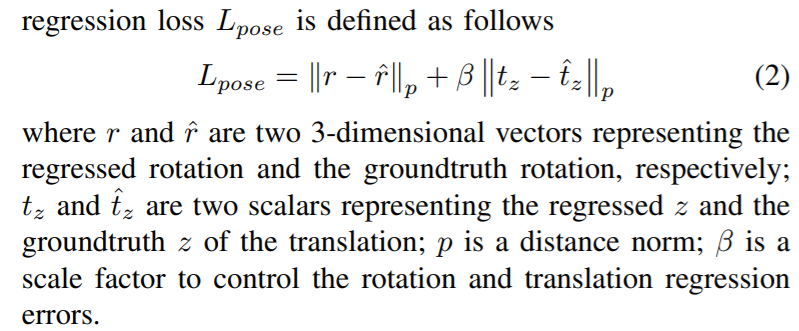

#### If you think it's useful, please give me an upvote, thanks.